Crameri-Tackley model
=======

From Cramer and Tackley 2015
--------






References
====




In [1]:
#pwd

Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [2]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import shutil

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [3]:
############
#Need to manually set these two
############
Model = "T"
ModNum = 10

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])


Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [4]:
#Do you want to write hdf5 files - Temp, RMS, viscosity, stress?
writeFiles = True
loadTemp = False
refineMesh = True

In [5]:
ETA_T = 1e5

newvisc= math.exp(math.log(ETA_T)*0.53)


In [6]:
newvisc


446.6835921509633

In [7]:
###########
#No rheology Constants
###########

TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)


D = 2890.

MINX = -1.
#Mesh refinement parameter
ALPHA = 11.

stickyAir = False

In [8]:

    
if MINX == 0.:
    squareModel = True
else: 
    squareModel = False


In [9]:
##########
#variables, these can be defined with STDIN,
##########
#The == '-f': check is just to check if we're running a notebook - careful, haven't tested
    
#Watch the type assignemnt on sys.argv[1]

DEFAULT = 128
ModIt   = str(DEFAULT)
    
    
if len(sys.argv) == 1:
    RES = DEFAULT
elif sys.argv[1] == '-f':
    RES = DEFAULT
else:
    RES = int(sys.argv[1])
    

In [10]:
outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

In [11]:
dim = 2          # number of spatial dimensions


if MINX == 0.:
    Xres = RES
else:
    Xres = 2*RES
    
if stickyAir:
    Yres = RES + 8
    MAXY = float(Yres)/RES
    
else:
    Yres = RES
    MAXY = 1.
    

In [12]:
outputPath, checkpointPath

('results/T/10/', 'results/T/10/checkpoint/')

In [13]:
Xres, Yres

(256, 128)

In [14]:
yelsize = MAXY/Yres
MAXY, yelsize, yelsize*D

(1.0, 0.0078125, 22.578125)

Select which case of viscosity from Tosi et al (2015) to use. Adjust the yield stress to be =1 for cases 1-4, or between 3.0 and 5.0 (in increments of 0.1) in case 5.

Set output file and directory for results

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [15]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(Xres, Yres), 
                                           minCoord=(MINX,0.), 
                                           maxCoord=(1.,MAXY), periodic=[True,False] )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [16]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )
temperatureDotField = uw.fevariable.FeVariable( feMesh=linearMesh,      nodeDofCount=1 )

Create some dummy fevariables for doing top and bottom boundary calculations.

##Refine mesh

if refineMesh:
    alpha=ALPHA
    newys = []
    newxs = []
    for index, coord in enumerate(linearMesh.data):
        y0 = coord[1]
        x0 = abs(coord[0])
        if y0 >= 1.0:
            newy = y0
        else:
            newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
        newx = (math.log((alpha/2.)*x0 + math.e) - 1)*(1/(math.log((alpha/2.) + math.e) - 1))
        if coord[0] <= 0:
            newx = -1.*newx
        newys.append(newy)
        newxs.append(newx)
        
    with linearMesh.deform_mesh():
        linearMesh.data[:,1] = newys
        linearMesh.data[:,0] = newxs

In [17]:
#THis one for the rectangular mesh

if refineMesh:
    alpha = ALPHA
    newys = []
    newxs = []
    for index, coord in enumerate(linearMesh.data):
        y0 = coord[1]
        x0 = abs(coord[0])
        if y0 >= 1.0:
            newy = y0
        else:
            newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
        if coord[0] > 0:
            newx = (math.e**(x0*(math.log((alpha/2.) + math.e) - 1) + 1 ) - math.e)/(alpha/2.)     
        else:
            newx = -1.*(math.e**(x0*(math.log((alpha/2.) + math.e) - 1) + 1 ) - math.e)/(alpha/2.)
        newys.append(newy)
        newxs.append(newx)
        #print y0,newy
        
    with linearMesh.deform_mesh():
            linearMesh.data[:,1] = newys
            linearMesh.data[:,0] = newxs

#Check if starting from checkpoint

In [18]:
checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/10/checkpoint/ is empty


#ICs and BCs

In [19]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

def wbl(x, w0 = 0.06):
    delx = 1- abs(x)
    Wbl = w0*math.sqrt(delx)
    return Wbl

wbl(1)


def tempf(z,w,t0=0.64):
    temp = t0*math.erf((1-z)/w)
    return temp

for index, coord in enumerate(linearMesh.data):
    w = wbl(coord[0])
    t = tempf(coord[1], w)
    temperatureField.data[index] = t


for index, coord in enumerate(linearMesh.data):
    if abs(coord[0]) < wbl(0)/2. and coord[1] > 0.5:
        w = wbl(0)/2.
        d = w - abs(coord[0])
        t = tempf(d, coord[1], w)
        temperatureField.data[index] = t
        
        

#Set sticky air Temp to zero

for index, coord in enumerate(linearMesh.data):
    if coord[1] > 1:
        temperatureField.data[index] = 0.


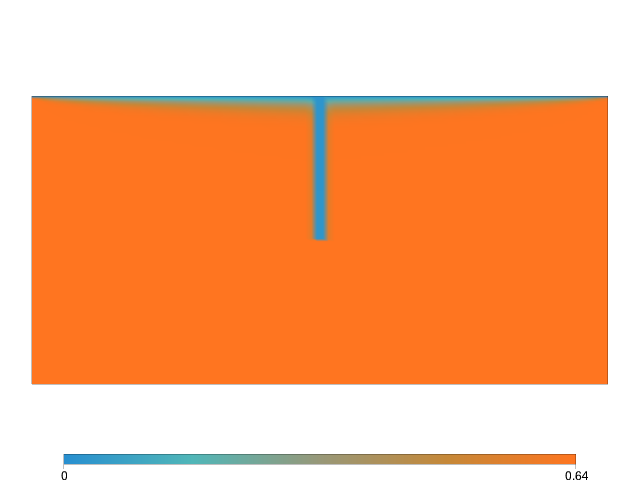

In [20]:
figTemp = glucifer.Figure()
figTemp + glucifer.objects.Surface(elementMesh, temperatureField)
figTemp.show()

In [21]:
#For notebook runs
#ModIt = "96"

In [22]:
##############
#a little workaround for change in Load Style
##############

import libUnderworld
def _oldload(self, path):
    libUnderworld.StgFEM.FeVariable_ReadFromFile( self._cself, path)
    
uw.fevariable._fevariable.FeVariable._oldload = _oldload # monkey patch fevariable
    

In [23]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
TWalls = linearMesh.specialSets["MaxJ_VertexSet"]
BWalls = linearMesh.specialSets["MinJ_VertexSet"]

In [24]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(None, JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(TWalls,) )

##Add Random 125 K temp perturbation


In [25]:
#tempNump = temperatureField.data
#for index, coord in enumerate(linearMesh.data):
#    pertCoeff = (0.05*np.random.rand(1)[0])
#    ict = tempNump[index]
#    tempNump[index] = ict + pertCoeff

##Reset bottom Dirichlet conds.

In [26]:
# Set temp boundaries 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 0.64
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

In [27]:
checkdirs

[]

#Particles

In [28]:
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )
materialVariable = gSwarm.add_variable( dataType="char", count=1 )
rockIntVar = gSwarm.add_variable( dataType="double", count=1 )
airIntVar = gSwarm.add_variable( dataType="double", count=1 )
lithIntVar = gSwarm.add_variable( dataType="double", count=1 )

varlist = [materialVariable, rockIntVar, airIntVar, lithIntVar]
varnames = ['materialVariable', 'rockIntVar', 'airIntVar', 'lithIntVar']

#Swarm checkpoint load

In [29]:
mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
airIndex = 3

#All depth conditions are given as (km/D) where D is the length scale, 
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#A few paramters defining lengths scales

Crust = 18.
CrustM = Crust/D


#######Setup some variables which help define condtions
#rock-air topography limits
dz = 15./D

avgtemp = 0.5

In [30]:
CrustM

0.006228373702422145

In [31]:
if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    temperatureField._oldload(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField._oldload(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField._oldload(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    #layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=20)
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=15)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Lets initialise the 'materialVariable' data to represent different materials
    # Set the material to heavy everywhere via the numpy array
    materialVariable.data[:] = mantleIndex
    
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
                 materialVariable.data[particleID] = airIndex
        elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < CrustM:
                 materialVariable.data[particleID] = crustIndex


In [32]:
#for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
#    if (abs(gSwarm.particleCoordinates.data[particleID][0]) < CrustM) and (gSwarm.particleCoordinates.data[particleID][1] < 1.0):
#        materialVariable.data[particleID] = crustIndex
        
    

#Material Graphs

In [33]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]


In [34]:
print( "unique values after swarm has loaded:" + str(np.unique(materialVariable.data[:])))


unique values after swarm has loaded:[0 2]


In [35]:
import networkx as nx

#######Graph object
DG = nx.DiGraph(field="Depth")

#######Nodes
#Note that the order of materials, deepest to shallowest is important 
DG.add_node(0, mat='mantle')
DG.add_node(1, mat='lithosphere')
DG.add_node(2, mat='crust')
DG.add_node(3, mat='air')


labels=dict((n,d['mat']) for n,d in DG.nodes(data=True))
pos=nx.spring_layout(DG) 


#######Edges
#anything to air
DG.add_edges_from([(0,3),(1,3), (2,3)])
DG[0][3]['depthcondition'] = -1*dz
DG[1][3]['depthcondition'] = -1*dz
DG[2][3]['depthcondition'] = -1*dz


#Anything to mantle
DG.add_edges_from([(2,0), (3,0), (1,0)])
DG[3][0]['depthcondition'] = dz
DG[2][0]['depthcondition'] = (300./D)
DG[1][0]['depthcondition'] = (660./D) #This means we're going to kill lithosphere at the 660.


#Anything to lithsphere
DG.add_edges_from([(0,1),(3,1)])
DG[0][1]['depthcondition'] = 200./D
DG[0][1]['avgtempcondition'] = 0.75*avgtemp #definition of thermal lithosphere


#Anything to crust
DG.add_edges_from([(0,2), (1,2)])
DG[0][2]['depthcondition'] = CrustM
DG[1][2]['depthcondition'] = CrustM

In [36]:
DG.nodes()

[0, 1, 2, 3]

In [37]:
remove_nodes = []
for node in DG.nodes():
    if not node in material_list:
        remove_nodes.append(node)
        
for rmnode in remove_nodes:
    DG.remove_node(rmnode)

In [38]:
DG.nodes()

[0, 1, 2, 3]

In [39]:
#remove_nodes = []
#for node in DG.nodes_iter():
#    if not node in material_list:
#        remove_nodes.append(node)
        
#for rmnode in remove_nodes:
#    DG.remove_node(rmnode)

In [40]:
#A Dictionary to map strings in the graph (e.g. 'depthcondition') to particle data arrays

particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
particletemps = temperatureField.evaluate(gSwarm)[:,0]

conditionmap = {}

conditionmap['depthcondition'] = {}
conditionmap['depthcondition']['data'] = particledepths
conditionmap['avgtempcondition'] = {}
conditionmap['avgtempcondition']['data'] = particletemps

In [41]:
def update_swarm(graph, particleIndex):
    """
    This function takes the materials graph (networkx.DiGraph), and a particle index,
    then determines if a material update is required 
    and if so, returns the new materialindex
    Args:
        graph (networkx.DiGraph): Directed multigraph representing the transformation of material types
        particleIndex (int): the particle index as corressponding to the index in the swarm data arrays
    Returns:
        if update is required the function returns the the new material variable (int) 
        else returns None
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    ##Egde gives links to other materials, we then query the conditions to see if we should change materials
    matId = materialVariable.data[particleIndex][0]
    innerchange = False
    outerchange = False
    for edge in graph[matId]:
        if outerchange:
            break
        for cond in graph[matId][edge].keys():
            outerchange = False
            if innerchange: #found a complete transition, break inner loop
                break
            currentparticlevalue = conditionmap[cond]['data'][particleIndex]
            crossover = graph[matId][edge][cond]
            if ((matId > edge) and (currentparticlevalue > crossover)):
                innerchange = False # continue on, 
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            elif ((matId < edge) and (currentparticlevalue < crossover)):
                innerchange = False
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            else:
                #condition not met, break outer loop, go to next edge, outerchange should still be False
                break
    if type(innerchange) == int:
        return innerchange

for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
                check = update_swarm(DG, particleID)
                #print check
                if check > -1:
                    #number_updated += 1
                    materialVariable.data[particleID] = check

In [42]:
#Cleanse the swarm of its sins
#For some Material Graphs, the graph may have to be treaversed more than once

check = -1
number_updated = 1

while number_updated != 0:
    number_updated = 0
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
                check = update_swarm(DG, particleID)
                if check > -1:
                    number_updated += 1
                    materialVariable.data[particleID] = check

In [43]:
#figtemp = plt.Figure()
#tempminmax = fn.view.min_max(temperatureField)
#figtemp.Surface(temperatureField, linearMesh)
#figtemp.VectorArrows(velocityField, linearMesh, lengthScale=0.5/velmax, arrowHeadSize=0.2 )
#figtemp.Points( swarm=gSwarm, colourVariable=materialVariable , pointSize=1.0)
#figtemp.Mesh(linearMesh, colourBar=False)
#figtemp.show()
#figtemp.save_database('test.gldb')

##Set the values for the masking swarms

In [44]:
#Setup up a masking Swarm variable for the integrations.
#Two possible problems? 
#does it work in parallel,
#How do we mange advecting this swarm?
#(might be best to just rebuild it every timestep, that way we only focus on advecting the material swarm)

rockIntVar.data[:] = 0.
notair = np.where(materialVariable.data != airIndex)
rockIntVar.data[notair] = 1.

airIntVar.data[:] = 0.
notrock = np.where(materialVariable.data == airIndex)
airIntVar.data[notrock] = 1.

lithIntVar.data[:] = 0.
islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
lithIntVar.data[islith] = 1.

##Set up a swarm for surface integrations¶


In [45]:
np.floor(10.*156/64)

24.0

In [46]:
snum = 1000.
dx = (linearMesh.data[:,0].max()- linearMesh.data[:,0].min())/snum
yp = 0.9947 #1. - yelsize/2. at res = 96

linearMesh.data[:,0].max()
xps = np.linspace(linearMesh.data[:,0].min(),linearMesh.data[:,0].max(), snum)
yps = [yp for i in xps]

surfintswarm = uw.swarm.Swarm( feMesh=elementMesh )
dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

yps = [ 1.- yp  for i in xps]

baseintswarm = uw.swarm.Swarm( feMesh=elementMesh )
dumout = baseintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

In [47]:
# visualise
#fig1 = plt.Figure()
#fig1.Points( swarm=surfintswarm, pointSize=10.0)
#fig1.Points( swarm=baseintswarm, pointSize=10.0)
#fig1.Points( swarm=gSwarm,colourVariable=rockIntVar)
#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.0002)
#fig1.Surface(temperatureField, linearMesh)
#
#fig1.Mesh(linearMesh, colourBar=False)
#fig1.show()

#Material properties


In [48]:
#Make variables required for plasticity

secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))

coordinate = fn.input()

depth = 1. - coordinate[1]


In [49]:
depthField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

depthField.data[:] = depth.evaluate(linearMesh)
depthField.data[np.where(depthField.data[:] < 0.)[0]] = 0.
#depthdata = depth.evaluate(linearMesh)

In [50]:
#Dimensional parameters
 
cohesion = 1e7 #i.e. 10 Mpa
D = 2890.
E = 240000. # J mol−1
R = 8.314 # m^3 mol
V = 6.34*(10**-7)
T0 = 273.
Tr = 1600.
rd = 0.0
g = 9.8
delT = 2500.
rho0 = 3300.
eta0 = 1e23
k = 10**(-6) 
fcb = 0.6 #friction coefficient from Byerlees' law


In [51]:
#scaling factors

stressscale  = (eta0*k)/(D*1000)**2

In [52]:
#Non-dimensional parameters

cohesionp = cohesion/stressscale

fc = 0.1 #mantle friction coefficient


fcc = 0.01 #crust friction coefficient
Ra = 1e6                                                                                                                                                                                                                                                   
Ep = E/(R*delT)
Vp = (rho0*9.81*V*(D*1000))/(R*delT)
Trp =1600./2500.
T0p = T0/2500.
rdp = 1.
fcbp = (fcb*rho0*g*(D*1000)**3)/(k*eta0)

print Ep, Vp, Trp, T0p,rdp, cohesionp,fcbp

11.5467885494 2.85377690546 0.64 0.1092 1.0 835.21 4683653.88876


In [53]:
#Compositional Rayligh number of rock-water 

g = 9.81
rho = 3300
a = 1.25*10**-5
kappa = 10**-6
dT = 2500
#eta0 = rho*g*a*dT*((D*1e3)**3)/(Ra*kappa)
eta0 = 1e23
#Composisitional Rayleigh number
Rc = (3300*g*(D*1000)**3)/(eta0*kappa)

CompRAfact = Rc/Ra

airviscosity = 0.001
airdensity = Ra*CompRAfact


In [54]:
eta0

1e+23

In [55]:
#Linear viscosity
coordinate = fn.input()
arhennius = fn.math.exp(((Ep + Vp*(1.-coordinate[1]))/(temperatureField + T0p)) - ((Ep + Vp*(1.- rdp))/(Trp + T0p)))
viscosityl = fn.misc.min(fn.misc.constant(1e5),arhennius)

In [56]:
pressureFieldCopy = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1)
pressureFieldCopy.data[:] = (pressureField.data - pressureField.data.max())*-1.

lithopressureField = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1)
lithopressuregrad = rho0*g*(D*1e3)**3/(eta0*kappa)

for index, coord in enumerate(constantMesh.data):
    lithopressureField.data[index] = (1.-coord[1])*lithopressuregrad
lithopressureField.data[lithopressureField.data < 0] = 0

In the paper, Crameri and Tackley give the dimensionless cohesion as well as the dimensionless yield stress gradient. But the latter is given as a function of dimensionless (lithostatic) pressure, whereas it is easier to use dimensionless depth. Easy, multiply the dimensionless depth by $\rho g D$, divide by the stress scale, $\frac{\eta \kappa}{D^2}$ then use the same dimensionless yeild stress gradient ($\mu$)

In [57]:
secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))

#Determine yield criterion for depth (rather than pressure as given in Crameri)

lithopressuregrad = rho0*g*(D*1e3)**3/(eta0*kappa)

############
#Mantle
############


#ycmd = 1577. + ((1.-coordinate[1])*(fc*lithopressuregrad))
ycmd = cohesionp + (fc*lithopressureField)

mantleviscosityp = ycmd/(secinvCopy/math.sqrt(0.5)) #extra factor to account for underworld second invariant form

#mantleviscosityFn = fn.exception.SafeMaths(fn.misc.min(viscosityl, mantleviscosityp))
mantleviscosityFn1 = fn.exception.SafeMaths(fn.misc.min(viscosityl, mantleviscosityp))
mantleviscosityFn = fn.misc.min(1e5,fn.misc.max(mantleviscosityFn1, 1e-4))

############
#crust
############

#yccd = (1577./10) + ((1.-coordinate[1])*((fc/10.)*lithopressuregrad))
#yccd = (1577./10.) + (fc/100.)*(lithopressureField)
yccd = 0.1*cohesionp + (0.001*fc*lithopressureField)
crustviscosityp = yccd/(secinvCopy/math.sqrt(0.5)) #extra factor to account for underworld second invariant form

#crustviscosityFn = fn.misc.min(viscosityl, crustviscosityp)
crustviscosityFn1 = fn.misc.min(viscosityl, crustviscosityp)
crustviscosityFn = fn.misc.min(1e5,fn.misc.max(crustviscosityFn1, 1e-4))


In [58]:
cohesionp

835.2100000000002

In [59]:
1e7*((D*1e3)**2/(eta0*kappa))

835.2100000000002

In [60]:
(((100/D)*lithopressuregrad)*0.1)/(1e7*((D*1e3)**2/(eta0*kappa)))

32.373000000000005

Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [61]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:airviscosity, lithosphereIndex:mantleviscosityFn, crustIndex:crustviscosityFn,mantleIndex:mantleviscosityFn} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:airdensity, lithosphereIndex:Ra*temperatureField, crustIndex:Ra*temperatureField, mantleIndex:Ra*temperatureField} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [62]:
#We first set up a l
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
#                              viscosityFn=viscosityFn1, 
                              viscosityFn=fn.exception.SafeMaths(viscosityl), 
                              bodyForceFn=buoyancyFn)

We do one solve with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [63]:
if not checkpointLoad:
    stokesPIC.solve()

In [64]:
#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

In [65]:
# Setup the Stokes system again, now with linear or nonlinear visocity viscosity.
stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityMapFn), 
                              bodyForceFn=buoyancyFn)

solver = uw.systems.Solver(stokesPIC2) # altered from PIC2

solver.options.main.Q22_pc_type='uwscale'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-6
solver.options.scr.ksp_rtol=1e-5
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.scr.ksp_set_max_it = 100
solver.options.mg.levels = 4
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1

In [66]:
solver = uw.systems.Solver(stokesPIC2) # altered from PIC2



solver.options.main.Q22_pc_type='uw'
solver.options.A11.ksp_rtol=1e-6
solver.options.scr.ksp_rtol=1e-5
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 6

solver.options.mg.levels = 4

solver.options.A11.ksp_monitor=''

Solve for initial pressure and velocity using a quick non-linear Picard iteration


In [67]:
solver.solve(nonLinearIterate=True)

Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [68]:
#Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField, diffusivity=1., conditions=[tempBC,] )

advector = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=1)

Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [69]:
#Setup some Integrals. We want these outside the main loop...
tempVariable = gSwarm.add_variable( dataType="double", count=1 )
tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
tempint = uw.utils.Integral((tempVariable*rockIntVar), linearMesh)


areaint = uw.utils.Integral((1.*rockIntVar),linearMesh)

v2int = uw.utils.Integral(fn.math.dot(velocityField,velocityField)*rockIntVar, linearMesh)


dwint = uw.utils.Integral(temperatureField*velocityField[1]*rockIntVar, linearMesh)

secinv = fn.tensor.second_invariant(
                    fn.tensor.symmetric(
                        velocityField.gradientFn ))

sinner = fn.math.dot(secinv,secinv)
vdint = uw.utils.Integral((4.*mantleviscosityFn*sinner)*rockIntVar, linearMesh)
vdintair = uw.utils.Integral((4.*mantleviscosityFn*sinner)*airIntVar, linearMesh)
vdintlith = uw.utils.Integral((4.*mantleviscosityFn*sinner)*lithIntVar, linearMesh)

In [70]:
def avg_temp():
    return tempint.evaluate()[0]

#This one gets cleaned up when Surface integrals are available
def nusselt(tempfield, swarm, dx):
    #Update the swarm variable
    tempgrad = tempfield.gradientFn
    valcheck = tempgrad[1].evaluate(swarm)
    if valcheck is None:
        vals = np.array(0, dtype='float64')
    else:
        vals = valcheck.sum()*dx
    return vals

def rms():
    return math.sqrt(v2int.evaluate()[0])

#This one gets cleaned up when Surface integrals are available
def rms_surf(swarm, dx):
    rmsmaxfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
    rmscheck = rmsmaxfn.evaluate(swarm)
    if rmscheck is None:
        rmsvals = np.array(0, dtype='float64')
    else:
        rmsvals = rmscheck.sum()*dx
    return rmsvals

def max_vx_surf(velfield, swarm):
    surfvelxmaxfn = fn.view.min_max(velfield[0])
    surfvelxmaxfn.evaluate(swarm)
    return surfvelxmaxfn.max_global()

def max_vy_surf(velfield, swarm):
    surfvelxmaxfn = fn.view.min_max(velfield[1])
    surfvelxmaxfn.evaluate(swarm)
    return surfvelxmaxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(linearMesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [71]:
#Fields for saving data / fields

rmsField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
rmsfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
rmsdata = rmsfn.evaluate(linearMesh)
rmsField.data[:] = rmsdata 

viscField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
viscdata = mantleviscosityFn.evaluate(linearMesh)
viscField.data[:] = viscdata


strainrateField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
srtdata = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))
rostfield = srtdata.evaluate(linearMesh)
strainrateField.data[:] = rostfield

viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)


In [72]:
#Images
figEta = glucifer.Figure()
figEta + glucifer.objects.Points(gSwarm,viscVariable, logScale=True)


figMat = glucifer.Figure()
figMat + glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red')
figMat + glucifer.objects.Mesh(linearMesh)


figStrainRate = glucifer.Figure()
figStrainRate + glucifer.objects.Surface(elementMesh, secinvCopy, logScale=True)


figVelocityMag = glucifer.Figure()
figVelocityMag + glucifer.objects.Surface(elementMesh, fn.math.dot(velocityField,velocityField))

figTemp = glucifer.Figure()
figTemp + glucifer.objects.Surface(elementMesh, temperatureField)



#Pack some stuff into a database as well
figDb = glucifer.Figure()
figDb + glucifer.objects.Points(gSwarm,viscVariable, colours='brown white blue red')
figDb + glucifer.objects.Mesh(linearMesh)
figDb + glucifer.objects.Surface(elementMesh, temperatureField)
figDb + glucifer.objects.Surface(elementMesh, secinvCopy, logScale=True)
                           

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [73]:
pics = uw.swarm.PICIntegrationSwarm(gSwarm)

In [74]:
steps_end = 5
steps_display_info = 20
swarm_update = 10
swarm_repop = 50
files_output = 20
gldbs_output = 5
images_output = 20
checkpoint_every = 20
metric_output = 1

In [75]:
def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    swarmfile = "materialSwarm" + ".hdf5"
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        filename.write((13*'%-15s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surf,Gravwork, etamax, etamin, Viscdisair, Viscdislith))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"), swarmfilepath=os.path.join(path, "swarm.h5"))
        
    

In [76]:
#step = 0
#f_o = open(outputPath+outputFile, 'w')
#checkpoint1(step, checkpointPath,f_o, metric_output)           
#checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
#varlist = [materialVariable, rockIntVar, airIntVar, lithIntVar]
#path = checkpointPath + str(step) 
#materialVariable.save(os.path.join(path,varnames[0] + ".h5"), swarmfilepath=os.path.join(path, "swarm.h5"))

In [ ]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
if checkpointLoad:
    if uw.rank == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    #os.rename(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]
# Perform steps
while realtime < 0.4:
#while step < 3:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    # Advect swarm using this timestep size
    advector.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    #Update any swarm variables and temperature field in the air region
    tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
    for index, coord in enumerate(linearMesh.data):
        if coord[1] >= 1.:
            temperatureField.data[index] = 0.   
    # Calculate the Metrics, only on 1 of the processors:
    if (step % metric_output == 0):
        tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
        Avg_temp = avg_temp()
        Rms = rms()
        Max_vx_surf = max_vx_surf(velocityField, surfintswarm)
        Gravwork = gravwork(dwint)
        Viscdis = viscdis(vdint)
        Viscdisair = viscdis(vdintair)
        Viscdislith = viscdis(vdintlith)
        etamax, etamin = visc_extr(mantleviscosityFn)
        #These are the ones that need mpi4py treatment
        Nu0loc = nusselt(temperatureField, baseintswarm, dx)
        Nu1loc = nusselt(temperatureField, surfintswarm, dx)
        Rmsurfloc = rms_surf(surfintswarm, dx)
        #Setup the global output arrays
        dTp = Nu0loc.dtype
        Nu0glob = np.array(0, dtype=dTp)
        dTp = Nu1loc.dtype
        Nu1glob = np.array(0, dtype=dTp)
        dTp = Rmsurfloc.dtype
        Rmsurfglob = np.array(0, dtype=dTp)
        #Do global sum
        comm.Allreduce(Nu0loc, Nu0glob, op=MPI.SUM)
        comm.Allreduce(Nu1loc, Nu1glob, op=MPI.SUM)
        comm.Allreduce(Rmsurfloc, Rmsurfglob, op=MPI.SUM)
        # output to summary text file
        if uw.rank()==0:
            f_o.write((13*'%-15s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surf,Gravwork, etamax, etamin, Viscdisair, Viscdislith))
    #if step %  steps_display_info == 0:
    # output image to file
    if (step % files_output == 0) & (writeFiles == True):
        ##Files to save
        fnametemp = "temperatureField" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        temperatureField.save(fullpath)
        #RMS
        fnamerms = "rmsField" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnamerms)
        rmsField.save(fullpath)
        #Strain rate invariant
        fnamestrainrate = "strainrateField" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnamestrainrate)
        strainrateField.save(fullpath)
    if (step % gldbs_output == 0) & (writeFiles == True):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figDb.show()
        figDb.save_database(fullpath)
    if (step % images_output == 0) & (writeFiles == True):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        iname1 = "viscFig" + "_" + str(ModIt) + "_" + str(step) + ".png"
        fullpath1 = os.path.join(outputPath + "images/" + iname1)
        iname2 = "matFig" + "_" + str(ModIt) + "_" + str(step) + ".png"
        fullpath2 = os.path.join(outputPath + "images/" + iname2)
        iname3 = "stFig" + "_" + str(ModIt) + "_" + str(step) + ".png"
        fullpath3 = os.path.join(outputPath + "images/" + iname3)
        iname4 = "v2Fig" + "_" + str(ModIt) + "_" + str(step) + ".png"
        fullpath4 = os.path.join(outputPath + "images/" + iname4)
        iname5 = "tempFig" + "_" + str(ModIt) + "_" + str(step) + ".png"
        fullpath5 = os.path.join(outputPath + "images/" + iname5)
        #
        figEta.show()
        figEta.save_image(fullpath1)
        figMat.show()
        figMat.save_image(fullpath2)
        figStrainRate.show()
        figStrainRate.save_image(fullpath3)
        figVelocityMag.show()
        figVelocityMag.save_image(fullpath4)
        figTemp.show()
        figTemp.save_image(fullpath5)
        
    ################
    #Particle update
    ###############
    particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
    particletemps = temperatureField.evaluate(gSwarm)[:,0]
    conditionmap['depthcondition']['data'] = particledepths
    conditionmap['avgtempcondition']['data'] = particletemps
    if step % swarm_update == 0:
        number_updated = 0
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            check = update_swarm(DG, particleID)
            if check > -1:
                number_updated += 1
                #if check == 0:
                #    print "from " + str(materialVariable.data[particleID]) + " to " + str(check)
                materialVariable.data[particleID] = check
            else:
                pass
        #Also update those integration swarms
        rockIntVar.data[:] = 0.
        notair = np.where(materialVariable.data != airIndex)
        rockIntVar.data[notair] = 1.
        airIntVar.data[:] = 0.
        notrock = np.where(materialVariable.data == airIndex)
        airIntVar.data[notrock] = 1.
        lithIntVar.data[:] = 0.
        islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
        lithIntVar.data[islith] = 1.
    #Also repopulate
    if step % swarm_repop == 0:
        pics.repopulate()
        
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a')

        
        
#checkpoint(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
f_o.close()
#checkpoint(step, checkpointPath)

0
1
2
3
4
5


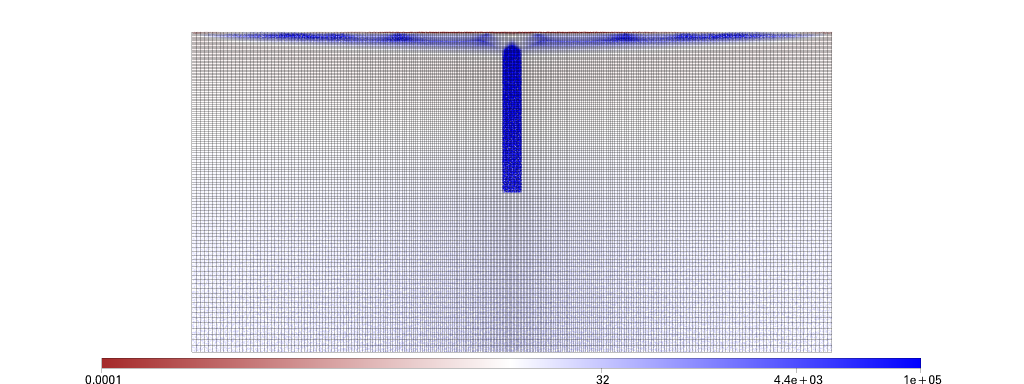

In [77]:
figEta = glucifer.Figure(figsize=(1024,384))
figEta + glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue')
figEta+ glucifer.objects.Mesh(linearMesh)
figEta.show()

#figEta.save_database('test.gldb')



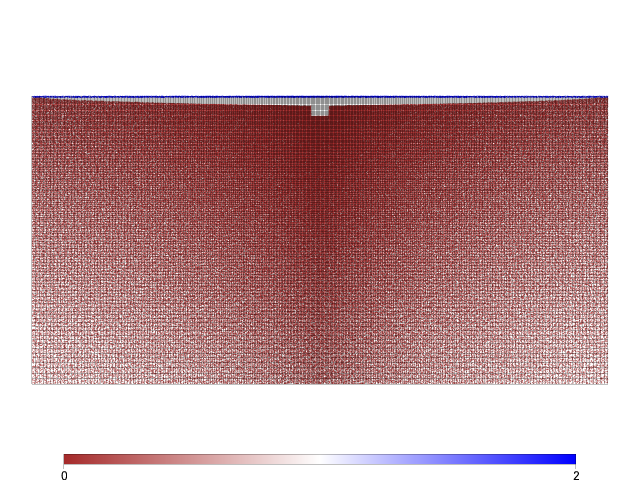

In [78]:
figMat = glucifer.Figure()
figMat + glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue')
figMat + glucifer.objects.Mesh(linearMesh)
figMat.show()

 

In [79]:
Ra

1000000.0

In [80]:
pressureField.data.max() - pressureField.data.min()

676340.53985194676


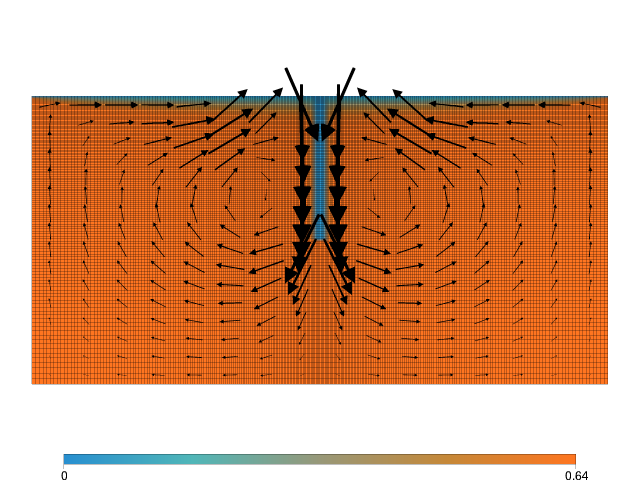

In [81]:
figTemp = glucifer.Figure()
figTemp + glucifer.objects.Surface(elementMesh, temperatureField)
figTemp + glucifer.objects.VectorArrows(elementMesh,velocityField, arrowHead=0.2, scaling=0.002)
figTemp+ glucifer.objects.Mesh(linearMesh)
figTemp.show()


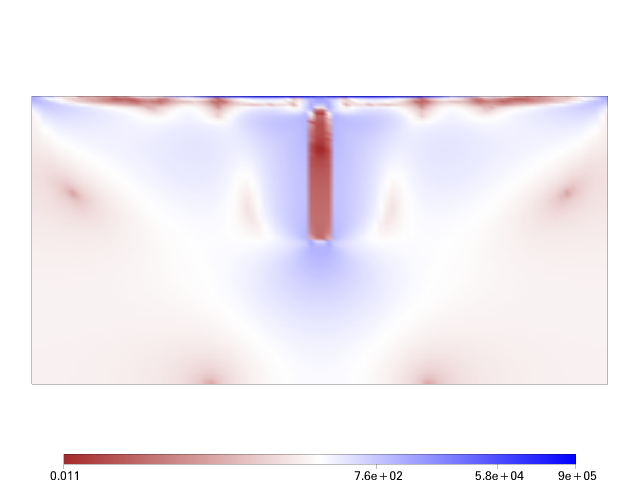

In [82]:
figStrainRate = glucifer.Figure()
figStrainRate + glucifer.objects.Surface(elementMesh, secinvCopy, logScale=True, colours='brown white blue')
figStrainRate.show()
#figStrainRate.save_database('test.gldb')


In [86]:
machine_time = (time.clock()-start)
print("total time is: " + str(machine_time))

NameError: name 'start' is not defined

In [87]:
#print("velocity max on horizontal bounds is: " + str(velocityField[0].evaluate(IWalls).max()))


In [93]:
#Sanity check for periodic conditions
velocityField.evaluate(IWalls)[:,0].max()

3.7719635834147605